In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import boost_histogram as bh
import tensorflow as tf
import sklearn as sk
import pandas as pd
import pyarrow.feather as feather
import sklearn.model_selection as model_selection
import os
import joblib

class DataLoader:
    def __init__(self, file_name, selected_labels):
        self.file_name = file_name
        self.selected_labels = selected_labels
        self.x_data, self.y_data, self.weight_data = self.import_feather()

    def import_feather(self):
        df = feather.read_feather(self.file_name)
        df = df.set_index(['entry', 'subentry'])

        weight_data = df['Event.Weight'][:,0].values.reshape(-1, 1)

        feature_columns = df.columns.intersection(self.selected_labels).tolist()
        selected_df = df[feature_columns].copy()
        Pflipped_df = self.parity_transform(df)
        Pflipped_weight_data = -Pflipped_df['Event.Weight'][:,0].values.reshape(-1, 1)

        selected_df = (selected_df.assign(counter=selected_df.groupby('entry').cumcount())
                       .pivot_table(index='entry', columns=['subentry'], values=feature_columns, dropna=False, fill_value=0))
        Pflipped_df = (Pflipped_df.assign(counter=Pflipped_df.groupby('entry').cumcount())
                       .pivot_table(index='entry', columns=['subentry'], values=feature_columns, dropna=False, fill_value=0))

        total_weight_data = np.concatenate([weight_data, Pflipped_weight_data], axis=0)
        y_data = (total_weight_data > 0).astype(int)
        x_data = np.concatenate([selected_df.to_numpy(), Pflipped_df.to_numpy()], axis=0)
        
        #Plotter.plot_kinematic_variable(selected_df, Pflipped_df, weight_data, 'Jet.Eta', 'WWW')
        #Plotter.plot_kinematic_variable(selected_df, Pflipped_df, weight_data, 'Electron.PT', 'WWW')
        #Plotter.plot_kinematic_variable(selected_df, Pflipped_df, weight_data, 'Muon.PT', 'WWW')

        print('x_data, y_data, total_weight_data', x_data.shape, y_data.shape, total_weight_data.shape)
        return x_data, y_data, total_weight_data
    
    @staticmethod
    def parity_transform(Pflipped_df):
        flip_mask = Pflipped_df.columns.str.contains(r'\.Eta')
        phi_mask = Pflipped_df.columns.str.contains(r'\.Phi')
        Pflipped_df.loc[:, flip_mask] *= -1 
        Pflipped_df.loc[:, phi_mask] += np.pi  

        plus_overflow_mask = Pflipped_df.loc[:, phi_mask] > np.pi
        minus_overflow_mask = Pflipped_df.loc[:, phi_mask] < -np.pi

        Pflipped_df.loc[:, phi_mask] = (Pflipped_df.loc[:, phi_mask] - 2 * np.pi * plus_overflow_mask).astype(np.float32)
        Pflipped_df.loc[:, phi_mask] = (Pflipped_df.loc[:, phi_mask] + 2 * np.pi * minus_overflow_mask).astype(np.float32)    

        return Pflipped_df

class CustomKerasClassifier(sk.base.BaseEstimator, sk.base.ClassifierMixin):
    def __init__(self, input_shape, learning_rate=0.001, neurons=16, layers=2, reg_strength=0.001, epochs=50, patience=2, dropout_rate=0, batch_size=256):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.neurons = neurons
        self.layers = layers
        self.reg_strength = reg_strength
        self.epochs = epochs
        self.patience = patience
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.model = None

    def build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.Input(shape=(self.input_shape,)))

        for _ in range(self.layers-1):
            model.add(tf.keras.layers.Dense(self.neurons, activation='relu'))

        model.add(tf.keras.layers.Dense(self.neurons, kernel_regularizer=tf.keras.regularizers.l2(self.reg_strength)))
        model.add(tf.keras.layers.Dropout(rate=self.dropout_rate))
        model.add(tf.keras.layers.Dense(2, activation='softmax'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, x_train, y_train, validation_data=(None, None)):
        self.model = self.build_model()
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=self.patience, restore_best_weights=True
        )

        history = self.model.fit(
            x_train, y_train, 
            validation_data=validation_data,  
            epochs=self.epochs, 
            batch_size=self.batch_size,
            verbose=0, 
            callbacks=[early_stopping]
        )

        self.history_ = history.history

        return self

    def predict(self, x):
        return self.model.predict(x).argmax(axis=1)

    def score(self, x, y):
        _, accuracy = self.model.evaluate(x, y, verbose=0)
        return accuracy

class MLModel:
    def __init__(self):
        self.model = None
        self.scaler = sk.preprocessing.StandardScaler()

    def data_preprocessing(self, x_data, y_data):
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)
        x_validate, x_test, y_validate, y_test = model_selection.train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
        
        self.scaler.fit(x_train)
        x_train = self.scaler.transform(x_train)
        x_test = self.scaler.transform(x_test)
        x_validate = self.scaler.transform(x_validate)

        return x_train, x_test, y_train, y_test, x_validate, y_validate

    def grid_search(self, x_data, y_data, param_grid, model_filename):
        x_train, x_test, y_train, y_test, x_validate, y_validate = self.data_preprocessing(x_data, y_data)
        input_shape = x_train.shape[1]

        CustomKerasClassifier.total_fits = np.prod([len(v) for v in param_grid.values()]) * 2

        model = CustomKerasClassifier(input_shape=input_shape)
        grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=4, verbose=2)
        grid_result = grid.fit(x_train, y_train, validation_data=(x_validate, y_validate))

        print("Best Accuracy: {:.4f} using {}".format(grid_result.best_score_, grid_result.best_params_))
        self.model = grid_result.best_estimator_.model
        self.model.save(model_filename)
        meta_data = {
            "history": self.model.history.history,
            "scaler": self.scaler,
            "accuracy": grid_result.best_score_,
            "best_params": grid_result.best_params_
        }

        joblib.dump(meta_data, model_filename.replace(".keras", "_meta_data.joblib"))

    def predict(self, x_data):
        x_data = self.scaler.transform(x_data)
        prediction = self.model.predict(x_data)
        
        return prediction
    
    def load_ML_model(model_filename):
        ml_model = MLModel()
        ml_model.model = tf.keras.models.load_model(model_filename)

        meta_data = joblib.load(model_filename.replace(".keras", "_meta_data.joblib"))

        history = meta_data["history"]
        ml_model.scaler = meta_data["scaler"]
        best_params = meta_data["best_params"]
        accuracy = meta_data["accuracy"]
        print("Model Accuracy: {:.4f} using best hyperparameters {}".format(accuracy, best_params))

        return ml_model, history
    
class Plotter:
    @staticmethod
    def plot_loss(history, region, model_filename):
        output_filename = model_filename.replace(".keras", ".png")
        training_loss = history['loss'] 
        validation_loss = history['val_loss']
        epochs = np.arange(1, len(training_loss) + 1)
        
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_loss, marker='x', linestyle='-', color='mediumblue', label='Training')
        plt.plot(epochs, validation_loss, marker='x', linestyle='-', color='red', label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss $O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.legend()
        plt.savefig(f"O_NN_loss_{output_filename}", dpi=1000, bbox_inches="tight")
        plt.show()
 
    @staticmethod
    def plot_accuracy(history, region, model_filename):
        output_filename = model_filename.replace(".keras", ".png")
        training_accuracy = history['accuracy'] 
        validation_accuracy = history['val_accuracy']
        epochs = np.arange(1, len(training_accuracy) + 1)

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, training_accuracy, marker='x', linestyle='-', color='mediumblue', label='Training')
        plt.plot(epochs, validation_accuracy, marker='x', linestyle='-', color='red', label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy $O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.legend()
        plt.savefig(f"O_NN_accuracy_{output_filename}", dpi=1000, bbox_inches="tight")
        plt.show()

    @staticmethod
    def chi_squared(observed, expected, uncertainty):
        chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)
        return chi_squared

    @staticmethod        
    def plot_ML_observable(ML_results, weight_data, region, model_filename):
        output_filename = model_filename.replace(".keras", ".png")
        scale_factor = 0.5

        ML_observable = ML_results[:, 1] - ML_results[:, 0]

        bin_number = 20
        range_limit = (-1, 1)

        histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
        print("ML and Weight shape", ML_observable.shape, weight_data.shape)
        histogram_0.fill(ML_observable, weight=weight_data)

        bin_widths = histogram_0.axes[0].widths
        differential_cross_section_0 = histogram_0.view() / bin_widths

        hist_0_squared = bh.Histogram(histogram_0.axes[0])
        hist_0_squared.fill(ML_observable, weight=weight_data**2)

        uncertainty_0 = np.sqrt(hist_0_squared.view()) / bin_widths

        bin_centers = histogram_0.axes[0].centers
        bin_edges = histogram_0.axes[0].edges

        chi_squared_1 = Plotter.chi_squared(differential_cross_section_0, 0, uncertainty_0)
        print("chi_squared_1 about y=0:", chi_squared_1)

        plt.figure()

        plt.hist(bin_edges[:-1], bins=bin_edges, weights=differential_cross_section_0 /scale_factor, label=r"$O_{NN}$", color='mediumblue', histtype='step')
        plt.errorbar(bin_centers, differential_cross_section_0 / scale_factor, yerr=uncertainty_0 /scale_factor, fmt='None', color='mediumblue')

        plt.title(f'$O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.xlabel(r'$O_{NN}$', fontsize=14)
        plt.ylabel(r'$d\sigma/dO_{NN}$ [fb]', fontsize=14)
        y_min, y_max = plt.ylim()
        plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.legend(frameon=False, fontsize=12)
        plt.savefig(f"O_NN_{output_filename}", dpi=1000, bbox_inches="tight")
        plt.show()

        fractional_uncertainty_0 = np.divide(
            uncertainty_0, differential_cross_section_0,
            out=np.zeros_like(uncertainty_0),
            where=differential_cross_section_0 != 0
        )

        print("O_NN Fractional Uncertainty:", fractional_uncertainty_0)

    @staticmethod        
    def plot_separate_ML_observable(ML_results, weight_data, region, model_filename):
        output_filename = model_filename.replace(".keras", ".png")
        scale_factor = 0.5
        weight_data = weight_data.flatten()
        ML_observable = ML_results[:, 1] - ML_results[:, 0]

        print("ML_results shape:", ML_results.shape)
        print("weight_data shape:", weight_data.shape)

        plus_mask = weight_data > 0
        plus_ML_observable = ML_observable[plus_mask]
        plus_weights = weight_data[plus_mask]
        minus_ML_observable = ML_observable[~plus_mask]
        minus_weights = weight_data[~plus_mask]

        bin_number = 20
        range_limit = (-1, 1)

        histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
        histogram_1 = histogram_0.copy()
        histogram_0.fill(plus_ML_observable, weight=plus_weights)
        histogram_1.fill(minus_ML_observable, weight=minus_weights)

        bin_widths = histogram_0.axes[0].widths
        differential_cross_section_0 = histogram_0.view() / bin_widths
        differential_cross_section_1 = histogram_1.view() / bin_widths

        hist_0_squared = bh.Histogram(histogram_0.axes[0])
        hist_0_squared.fill(plus_ML_observable, weight=plus_weights**2)
        hist_1_squared = bh.Histogram(histogram_1.axes[0])
        hist_1_squared.fill(minus_ML_observable, weight=minus_weights**2)

        uncertainty_0 = np.sqrt(hist_0_squared.view()) / bin_widths
        uncertainty_1 = np.sqrt(hist_1_squared.view()) / bin_widths

        bin_centers = histogram_0.axes[0].centers
        bin_edges = histogram_0.axes[0].edges

        #chi_squared_1 = Plotter.chi_squared(differential_cross_section_0, 0, uncertainty_0)
        #print("chi_squared_1 about y=0:", chi_squared_1)

        plt.figure()

        plt.hist(bin_edges[:-1], bins=bin_edges, weights=differential_cross_section_0 /scale_factor, label=r"$O_{NN}^{+}$", color='mediumblue', histtype='step')
        plt.errorbar(bin_centers, differential_cross_section_0 / scale_factor, yerr=uncertainty_0 /scale_factor, fmt='None', color='mediumblue')
        plt.hist(bin_edges[:-1], bins=bin_edges, weights=abs(differential_cross_section_1 /scale_factor), label=r"$O_{NN}^{-}$", color='red', histtype='step')
        plt.errorbar(bin_centers, abs(differential_cross_section_1 / scale_factor), yerr=uncertainty_1 /scale_factor, fmt='None', color='red')

        plt.title(f'$O_{{NN}}$ for ${region}$ region', fontsize=14)
        plt.xlabel(r'$O_{NN}$', fontsize=14)
        plt.ylabel(r'$d\sigma/dO_{NN}$ [fb]', fontsize=14)
        y_min, y_max = plt.ylim()
        plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.legend(frameon=False, fontsize=12)
        plt.savefig(f"O_NN_{output_filename}", dpi=1000, bbox_inches="tight")
        plt.show()

        fractional_uncertainty_0 = np.divide(
            uncertainty_0, differential_cross_section_0,
            out=np.zeros_like(uncertainty_0),
            where=differential_cross_section_0 != 0
        )

        print("O_NN Fractional Uncertainty:", fractional_uncertainty_0)

    @staticmethod
    def plot_kinematic_variable(selected_df, Pflipped_df, weight_data, kinematic_variable, region):
        observable = selected_df[kinematic_variable].iloc[:, 0].to_numpy()
        flipped_observable = Pflipped_df[kinematic_variable].iloc[:, 0].to_numpy()
        print("observable", observable)
        print(f"max observable {kinematic_variable}", np.max(observable))
        print(f"min observable {kinematic_variable}", np.min(observable))
        print(f"observable shape {kinematic_variable}", (observable.shape))
        
        bin_number = 20
        range_limit = (np.min(observable), np.max(observable))

        histogram_0 = bh.Histogram(bh.axis.Regular(bin_number, *range_limit, underflow=False, overflow=False))
        histogram_1 = histogram_0.copy()
        print('ML + Weight shape', observable.shape, weight_data.shape)
        histogram_0.fill(observable, weight=weight_data)
        histogram_1.fill(flipped_observable, weight=weight_data)

        bin_widths = histogram_0.axes[0].widths
        differential_cross_section_0 = histogram_0.view() / bin_widths
        differential_cross_section_1 = histogram_1.view() / bin_widths

        hist_0_squared = bh.Histogram(histogram_0.axes[0])
        hist_1_squared = bh.Histogram(histogram_1.axes[0])
        hist_0_squared.fill(observable, weight=weight_data**2)
        hist_1_squared.fill(flipped_observable, weight=weight_data**2)
        bin_edges = histogram_0.axes[0].edges
    
        plt.figure()

        plt.hist(bin_edges[:-1], bins=bin_edges, weights=differential_cross_section_0, label=r'Selected data', color='mediumblue', histtype='step')
        plt.hist(bin_edges[:-1], bins=bin_edges, weights=differential_cross_section_1, label=r'PFlipped data', color='red', histtype='step')

        plt.title(f'{kinematic_variable.replace(".", " ")} for ${region}$ region', fontsize=14)
        plt.xlabel(r'$O$', fontsize=14)
        plt.ylabel(r'$d\sigma/dO$ [fb]', fontsize=14)
        y_min, y_max = plt.ylim()
        plt.ylim(y_min, y_max + 0.20 * (y_max - y_min))
        plt.xticks(fontsize=12)  
        plt.yticks(fontsize=12)
        plt.legend(frameon=False, fontsize=12)
        plt.savefig(f'{kinematic_variable.replace(".", "_")}_{region}_decomposition.png', dpi=1000, bbox_inches='tight')
        plt.show()


x_data, y_data, total_weight_data (169076, 108) (169076, 1) (169076, 1)
Loading existing model for vbs_lj_eta_phi_pt.keras
Model Accuracy: 0.7198 using best hyperparameters {'batch_size': 128, 'dropout_rate': 0.1, 'layers': 4, 'learning_rate': 0.001, 'neurons': 64, 'patience': 2, 'reg_strength': 0.001}
5284/5284 ━━━━━━━━━━━━━━━━━━━━ 5s 926us/step
ML and Weight shape (169076,) (169076, 1)
chi_squared_1 about y=0: 49670.03098036253


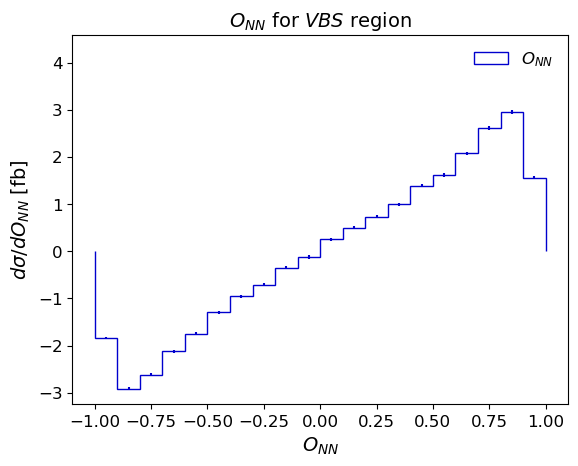

O_NN Fractional Uncertainty: [-0.01522628 -0.0125108  -0.01397186 -0.01670077 -0.02005077 -0.02624096
 -0.03398082 -0.04678347 -0.09634076 -0.30242182  0.13237194  0.06581624
  0.04368752  0.03230248  0.02332926  0.0203904   0.01664237  0.01393854
  0.01234977  0.01678   ]
ML_results shape: (169076, 2)
weight_data shape: (169076,)


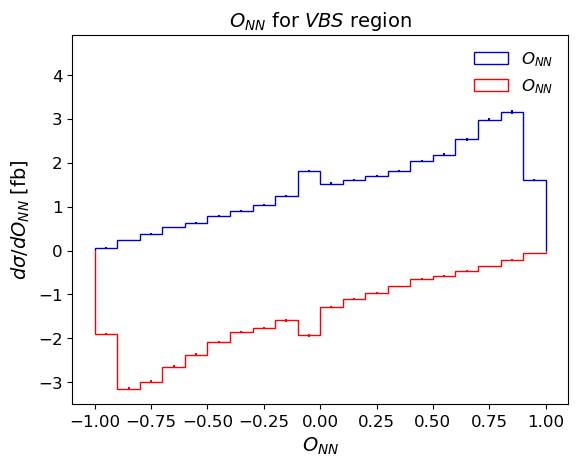

O_NN Fractional Uncertainty: [0.07328783 0.03913376 0.0318988  0.02678647 0.02507647 0.02288284
 0.02089884 0.01947371 0.01800966 0.01478884 0.01593197 0.01570552
 0.01517534 0.01467723 0.01384379 0.01349211 0.01257076 0.01159862
 0.01119309 0.01592589]


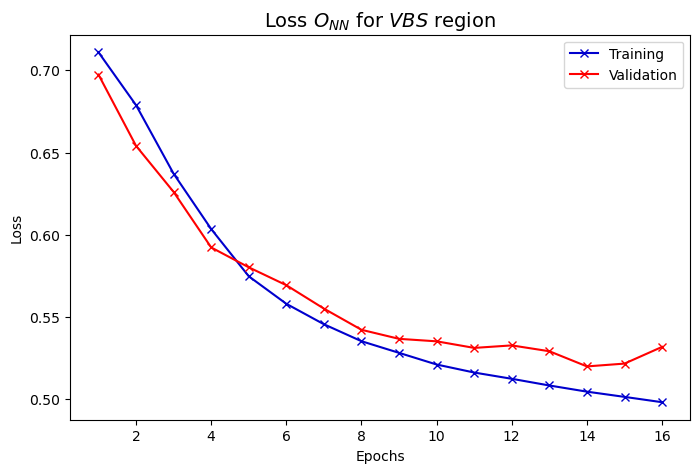

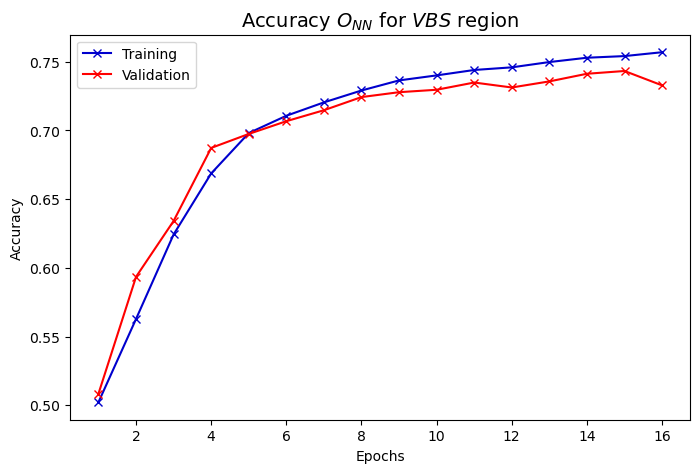

In [52]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Electron.Eta', 'Electron.Phi', 'Electron.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.PT'])
    model_filename = "vbs_lj_eta_phi_pt.keras"

    param_grid = {
            'learning_rate': [0.001, 0.01],
            'neurons': [16, 32, 64],
            'layers': [2, 3, 4],
            'reg_strength': [0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.1],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ML_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ML_observable(vbs_results, vbs_data.weight_data, "VBS", model_filename)
    Plotter.plot_separate_ML_observable(vbs_results, vbs_data.weight_data, "VBS", model_filename)
    Plotter.plot_loss(vbs_history, "VBS", model_filename)
    Plotter.plot_accuracy(vbs_history, "VBS", model_filename)

if __name__ == '__main__':
    __main__()

x_data, y_data, total_weight_data (169076, 48) (169076, 1) (169076, 1)
No existing model found, training new model
Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=   8.9s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  13.3s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  14.1s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  18.8s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  12.8s
[CV] END batch_size=256, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  12.9s
[CV] END batch_size=256, d

/home/finfullerton/mambaforge/envs/mphys/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0; total time=  13.6s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=32, patience=2, reg_strength=0.001; total time=  23.3s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.0001; total time=  29.1s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.001; total time=  23.5s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.001; total time=  22.8s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.0001; total time=  23.0s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0; total time=  26.5s
[CV] END batch_size=256, dropout_rate=0, layers=3, learning_

/tmp/ipykernel_900/1852406207.py:200: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


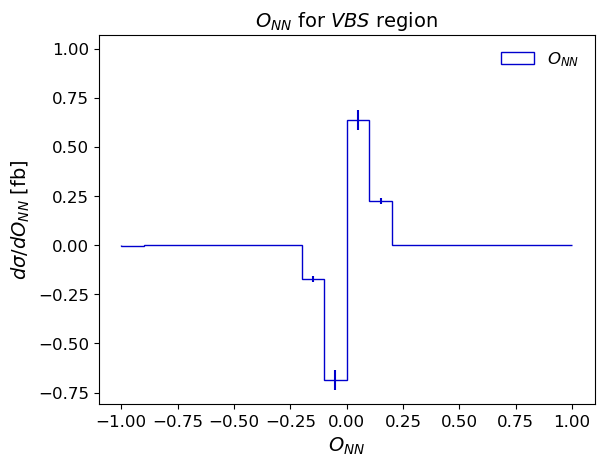

O_NN Fractional Uncertainty: [-3.61474139e-01  0.00000000e+00 -9.96955088e-01  1.51606934e+02
  1.23818911e+02 -3.19561687e+00  1.88433640e+00 -1.73255370e+00
 -8.58395526e-02 -7.63140015e-02  7.78640627e-02  7.35014849e-02
  8.81190461e-01  0.00000000e+00  1.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  9.99999972e-01  6.19458935e-01]


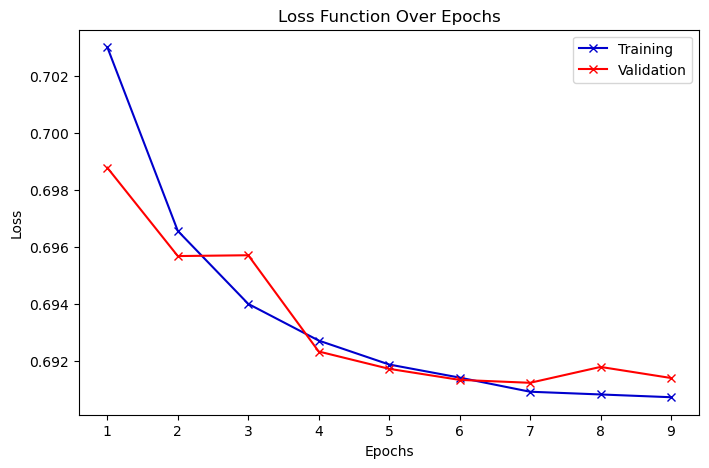

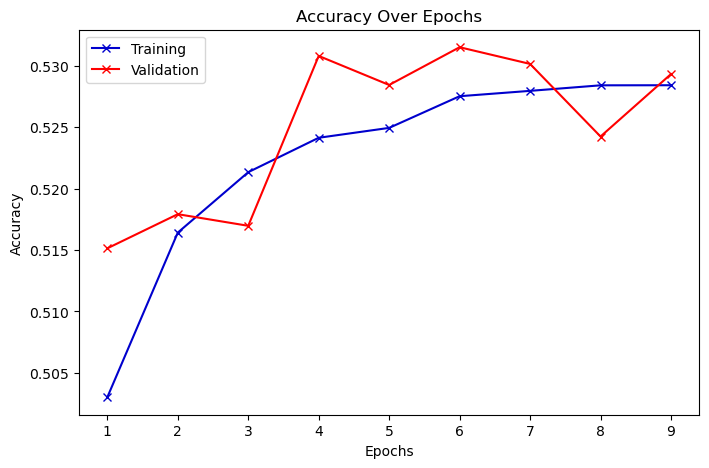

In [ ]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi'])
    model_filename = "vbs_l_eta_phi_2.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 3, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [256],
            'dropout_rate': [0, 0.1, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ML_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ML_observable(vbs_results, vbs_data.weight_data, "VBS", 2)
    Plotter.plot_loss(vbs_history)
    Plotter.plot_accuracy(vbs_history)

if __name__ == '__main__':
    __main__()

x_data, y_data, total_weight_data (169076, 24) (169076, 1) (169076, 1)
Loading existing model for vbs_j_eta_phi_2.keras
Model Accuracy: 0.7088 using best hyperparameters {'batch_size': 128, 'dropout_rate': 0.1, 'layers': 4, 'learning_rate': 0.001, 'neurons': 16, 'patience': 2, 'reg_strength': 0.001}
5284/5284 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
ML and Weight shape (169076,) (169076, 1)
chi_squared_1 about y=0: 31673.67008935061


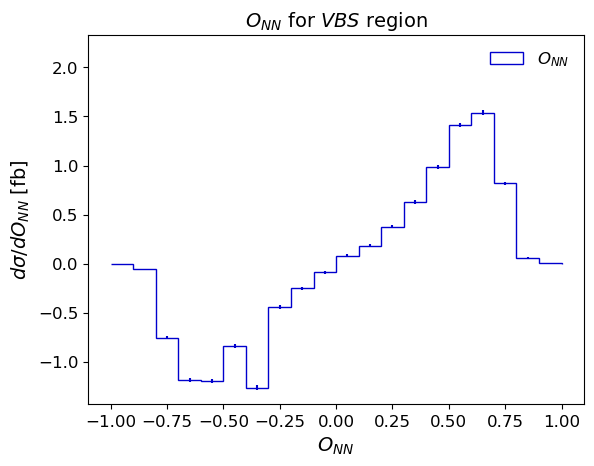

O_NN Fractional Uncertainty: [-0.22360961 -0.06712773 -0.01860172 -0.01626247 -0.01724699 -0.02258137
 -0.02135403 -0.04096044 -0.06510762 -0.17546403  0.19928779  0.08842203
  0.04554575  0.02940729  0.02085353  0.01590048  0.01397794  0.01840644
  0.06340677  0.25467709]


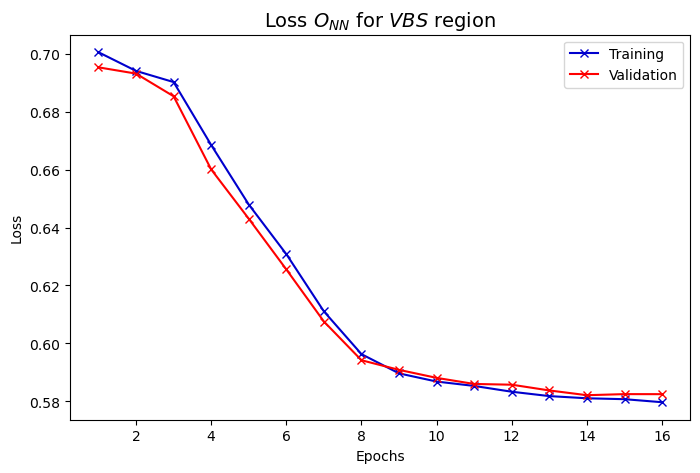

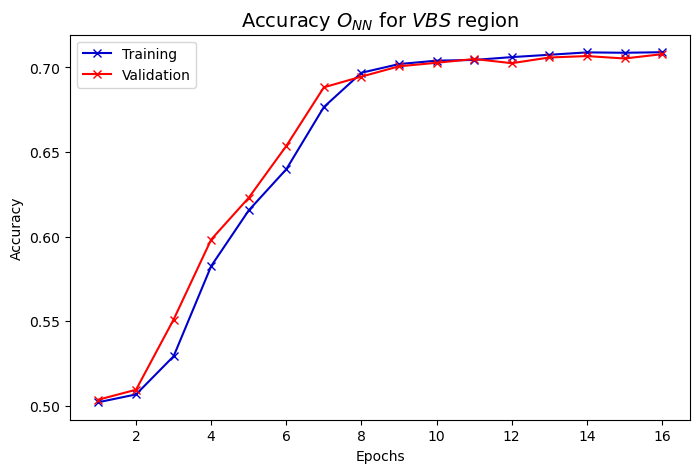

In [37]:
def __main__():
    vbs_data = DataLoader("VBS_data_cwtil_2.feather", ['Jet.Eta', 'Jet.Phi'])
    model_filename = "vbs_j_eta_phi_2.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 3, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.1, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        vbs_model = MLModel()
        vbs_model.grid_search(vbs_data.x_data, vbs_data.y_data, param_grid, model_filename)
    
    vbs_model, vbs_history = MLModel.load_ML_model(model_filename)

    vbs_results = vbs_model.predict(vbs_data.x_data)
    Plotter.plot_ML_observable(vbs_results, vbs_data.weight_data, "VBS", model_filename)
    Plotter.plot_loss(vbs_history, "VBS", model_filename)
    Plotter.plot_accuracy(vbs_history, "VBS", model_filename)

if __name__ == '__main__':
    __main__()

x_data, y_data, total_weight_data (69132, 99) (69132, 1) (69132, 1)
Loading existing model for www_lj_eta_phi_pt.keras
Model Accuracy: 0.5028 using best hyperparameters {'batch_size': 128, 'dropout_rate': 0.1, 'layers': 3, 'learning_rate': 0.001, 'neurons': 16, 'patience': 2, 'reg_strength': 0.0001}
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
ML and Weight shape (69132,) (69132, 1)
chi_squared_1 about y=0: nan


/tmp/ipykernel_921/3972501894.py:208: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


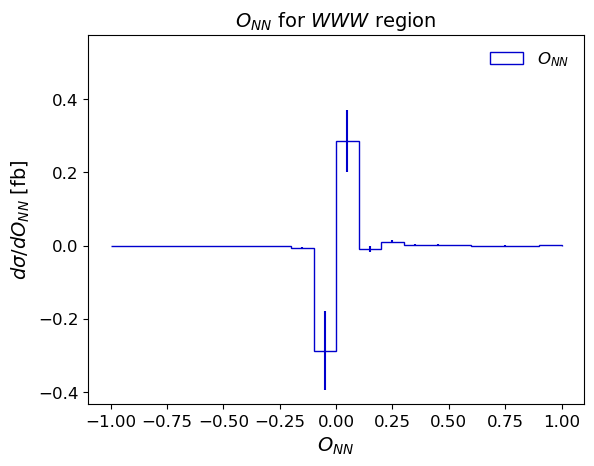

O_NN Fractional Uncertainty: [-1.00000001 -1.00000001  0.          0.          0.          0.
 -1.00000001 -0.73917997 -0.37996455 -0.38059859  0.29399015 -0.7931733
  0.43254862  0.71870852  0.50000089  0.70710896  0.          0.
  0.          0.57735691]
ML_results shape: (69132, 2)
weight_data shape: (69132,)


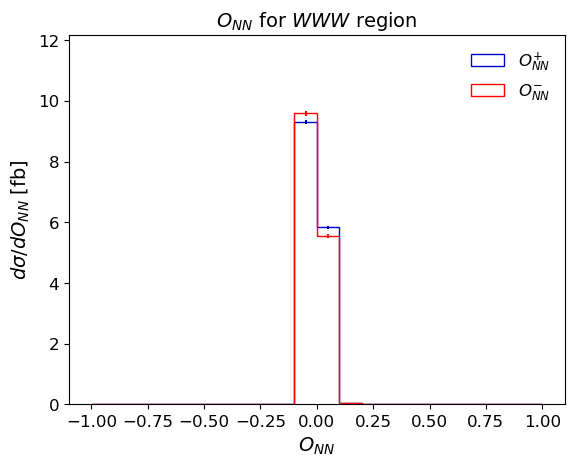

O_NN Fractional Uncertainty: [0.         0.         0.         0.         0.         0.
 0.         1.00000002 0.62762716 0.00821838 0.01032749 0.12798358
 0.23350228 0.36628396 0.50000089 0.70710896 0.         0.99999999
 0.         0.57735691]


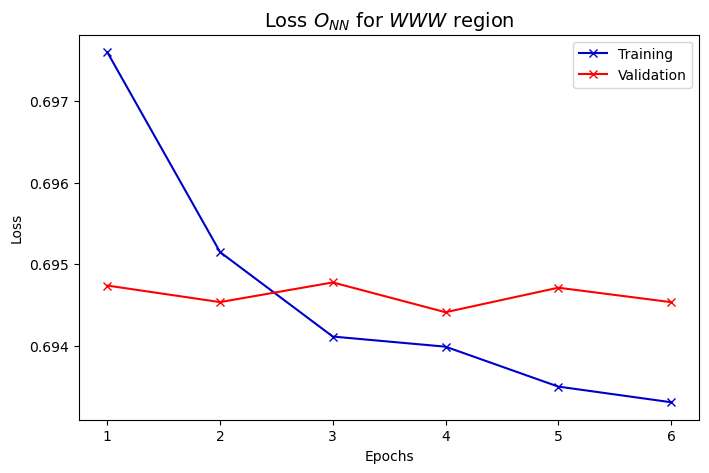

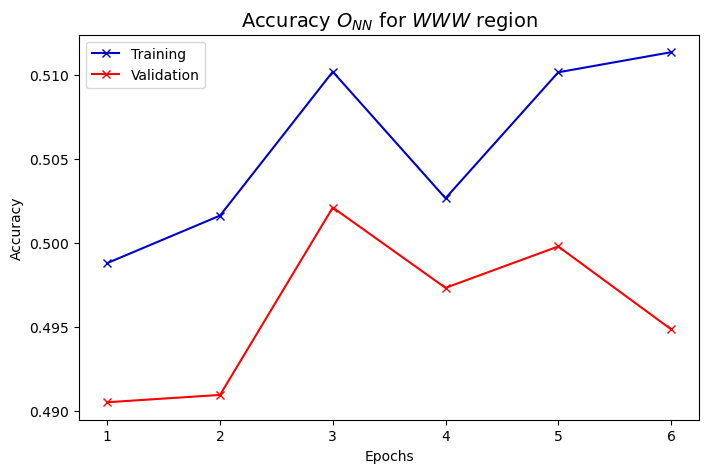

In [61]:
def __main__():
    www_data = DataLoader("WWW_data_cwtil_large_1.feather", ['Electron.Eta', 'Electron.Phi', 'Electron.PT', 'Muon.Eta', 'Muon.Phi', 'Muon.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.PT'])
    model_filename = "www_lj_eta_phi_pt.keras"

    param_grid = {
            'learning_rate': [0.001, 0.01],
            'neurons': [16, 32, 64],
            'layers': [2, 3, 4],
            'reg_strength': [0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.1],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        www_model = MLModel()
        www_model.grid_search(www_data.x_data, www_data.y_data, param_grid, model_filename)
    
    www_model, www_history = MLModel.load_ML_model(model_filename)

    www_results = www_model.predict(www_data.x_data)
    Plotter.plot_ML_observable(www_results, www_data.weight_data, "WWW", model_filename)
    Plotter.plot_separate_ML_observable(www_results, www_data.weight_data, "WWW", model_filename)
    Plotter.plot_loss(www_history, "WWW", model_filename)
    Plotter.plot_accuracy(www_history, "WWW", model_filename)

if __name__ == '__main__':
    __main__()

x_data, y_data, total_weight_data (69132, 44) (69132, 1) (69132, 1)
No existing model found, training new model
Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=   5.9s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=   6.7s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=   7.6s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  11.2s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=   9.8s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=   9.3s
[CV] END batch_size=128, drop

/home/finfullerton/mambaforge/envs/mphys/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=64, patience=2, reg_strength=0.001; total time=  10.2s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0; total time=  11.3s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.0001; total time=  16.9s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.0001; total time=  18.5s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0; total time=   8.9s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.001; total time=  14.4s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.001; total time=  11.5s
[CV] END batch_size=128, dropout_rate=0, layers=3, learn

/tmp/ipykernel_921/1908327891.py:208: RuntimeWarning: invalid value encountered in divide
  chi_squared = np.sum(((observed - expected) / uncertainty) ** 2)


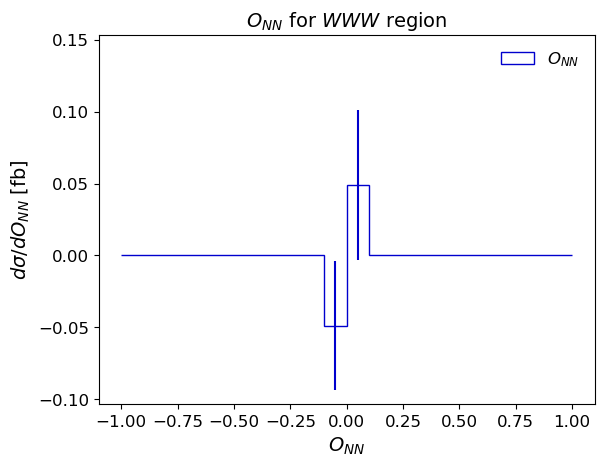

O_NN Fractional Uncertainty: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.92565215  1.06705566  0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


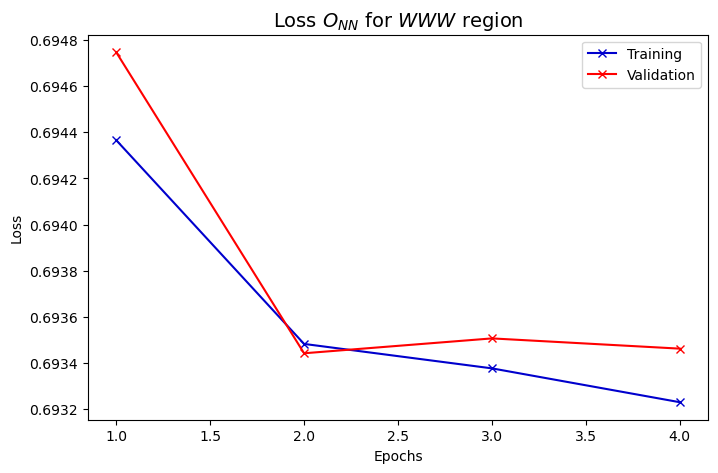

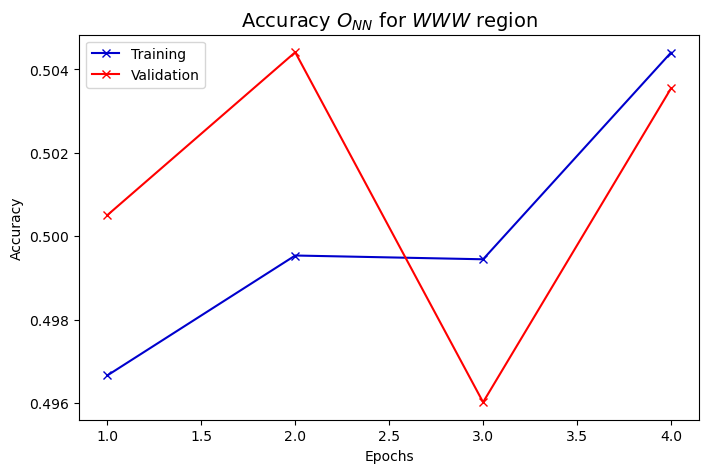

In [40]:
def __main__():
    www_data = DataLoader("WWW_data_cwtil_large_1.feather", ['Electron.Eta', 'Electron.Phi', 'Muon.Eta', 'Muon.Phi'])
    model_filename = "www_l_eta_phi_2.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 3, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.1, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        www_model = MLModel()
        www_model.grid_search(www_data.x_data, www_data.y_data, param_grid, model_filename)
    
    www_model, www_history = MLModel.load_ML_model(model_filename)

    www_results = www_model.predict(www_data.x_data)
    Plotter.plot_ML_observable(www_results, www_data.weight_data, "WWW", model_filename)
    Plotter.plot_loss(www_history, "WWW", model_filename)
    Plotter.plot_accuracy(www_history, "WWW", model_filename)

if __name__ == '__main__':
    __main__()

x_data, y_data, total_weight_data (69132, 22) (69132, 1) (69132, 1)
No existing model found, training new model
Fitting 2 folds for each of 324 candidates, totalling 648 fits
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=   8.4s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=   9.0s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0; total time=  11.5s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=16, patience=2, reg_strength=0.0001; total time=  12.2s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=   8.6s
[CV] END batch_size=128, dropout_rate=0, layers=2, learning_rate=0.001, neurons=32, patience=2, reg_strength=0; total time=  10.8s
[CV] END batch_size=128, drop

/home/finfullerton/mambaforge/envs/mphys/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.001, neurons=128, patience=2, reg_strength=0.0001; total time=  21.6s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0; total time=   8.4s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0; total time=   9.7s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0.0001; total time=   7.5s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0.001; total time=   8.2s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=16, patience=2, reg_strength=0.001; total time=   7.5s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate=0.005, neurons=32, patience=2, reg_strength=0; total time=   6.9s
[CV] END batch_size=128, dropout_rate=0, layers=3, learning_rate

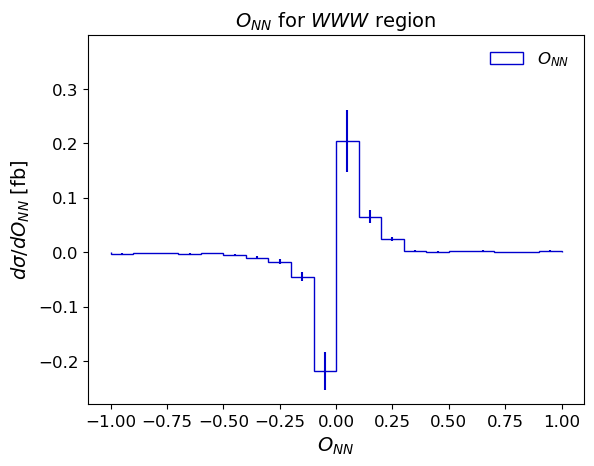

O_NN Fractional Uncertainty: [-0.34252596 -0.47018028 -0.50223995 -0.58848966 -0.50361144 -0.42668882
 -0.27357437 -0.23021262 -0.18072777 -0.16287401  0.27780541  0.18885779
  0.1722075   0.68911024  2.10724115  0.43584532  0.63905653  0.70710701
  0.57735168  0.32412514]


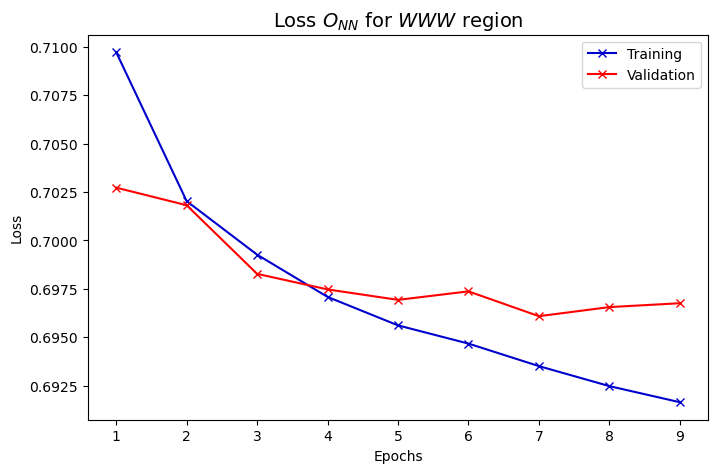

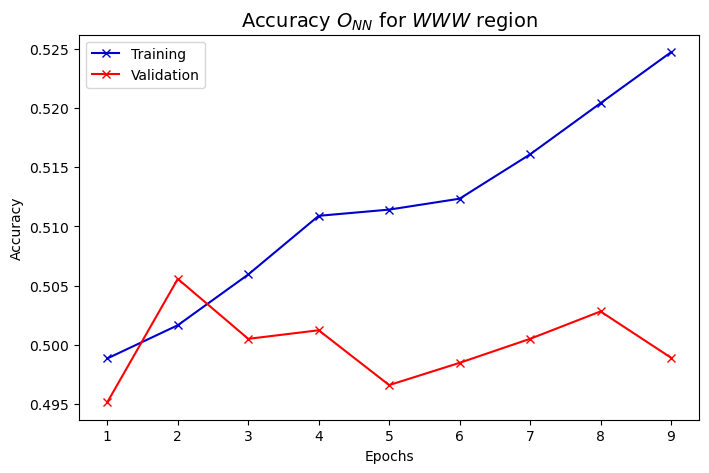

In [39]:
def __main__():
    www_data = DataLoader("WWW_data_cwtil_large_1.feather", ['Jet.Eta', 'Jet.Phi'])
    model_filename = "www_j_eta_phi_2.keras"

    param_grid = {
            'learning_rate': [0.001, 0.005, 0.01],
            'neurons': [16, 32, 64, 128],
            'layers': [2, 3, 4],
            'reg_strength': [0, 0.0001, 0.001],
            'patience': [2],
            'batch_size': [128],
            'dropout_rate': [0, 0.1, 0.2],
        }

    if os.path.exists(model_filename):
        print(f"Loading existing model for {model_filename}")
    else:
        print("No existing model found, training new model")
        www_model = MLModel()
        www_model.grid_search(www_data.x_data, www_data.y_data, param_grid, model_filename)
    
    www_model, www_history = MLModel.load_ML_model(model_filename)

    www_results = www_model.predict(www_data.x_data)
    Plotter.plot_ML_observable(www_results, www_data.weight_data, "WWW", model_filename)
    Plotter.plot_loss(www_history, "WWW", model_filename)
    Plotter.plot_accuracy(www_history, "WWW", model_filename)

if __name__ == '__main__':
    __main__()